In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Original Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

This notebook is based on the tutorial by Sasank Chilamkurthy. The content is the same, but it adds a few comments to explain some of the operations. What follows is from the original document.

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.

Transformations
--------------

Below we combine a number of image transformations:
1. `RandomResizedCrop` crops an image to a given size and aspect ratio. A random scale between $min$ and $max$ (by default $min=0.08$ and $max=1.0$), and a random aspect ratio (by default between 3/4 and 4/3) are selected. This crop is then resized to the specified size. Note that there are other cropping functions, like `CenterCrop` and `RandomCrop`.
2. `RandomHorizontalFlip`: flips the image along the horizontal axis with probability 0.5.
3. `ToTensor`: converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. There is also the inverse transformation `ToPILImage`.
4. `Normalize`: normalize a tensor (not a numpy array) by providing a mean value and a standard deviation for each channel.

There are many other transformations available in `torchvision`, and they can be checked at the [transforms page](http://pytorch.org/docs/master/torchvision/transforms.html). Note also that it is possible to pass a user-defined transformation function via `torchvision.transforms.Lambda`.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.4, 1.0)), # Default is (0.08, 1.0)
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
---------------------

Let's visualize a few training images so as to understand the data
augmentations. Note that we need to turn the tensors back to Numpy arrays and to put the channels at the end by `transpose`. We also need to add back the mean and multiply by the standard deviation. **Note:** we need to use the `clip` operation since the RGB values must be between 0.0 and 1.0. If we don't un-normalize the values we obtain a saturated image.

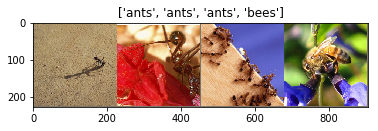

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

The `torchvision` module contains a large number of pretrained models in the `models` submodule. We write a general function to train a model that accepts a learning rate scheduler and a model saver. The schedulers are defined in ``torch.optim.lr_scheduler``. Note that `module.state_dict()` returns a dictionary containing a whole state of the module, which includes parameters and persistent buffers (e.g. running averages). The function below runs training and validation on a generic model, irrespective of its weigths being frozen or not. We will first apply to the full model, i.e., we will backpropagate through all the layers. In the second example we will freeze all but the last FC layer. The `model` argument is of class `nn.Module`, and the `train` argument's purpose is to run (or not) the Dropout and BatchNorm operations.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Let's go through the code of this function. we save the state of the best model into the dictionary `best_model_wts`. We then train for 25 epochs and process the training and the test sets. During the training phase we step the learning rate at each epoch. Here we are loading a model but we are re-training it from scratch.

Visualizing the model predictions
-------------------------------

Generic function to display predictions for a few images

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer. The weights of the model are initially retained, except the final FC layer that is completely reset, but during training we backpropagate through the whole network, and therefore fine-tune the weights of the whole model. Considering how little data we have, we expect to perform less well than by just using the pre-trained weights as a fixed feature extractor, as shown in the next example. The learning rate scheduler is useful because our weights are supposed to be already quite good, and we don't want to "overshoot" when fine-tuning.

**Exercise:** show that using a fixed learning rate produces worse results.

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1443 Acc: 0.7172
val Loss: 0.0448 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.0941 Acc: 0.8361
val Loss: 0.0652 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.1112 Acc: 0.8279
val Loss: 0.1160 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.1295 Acc: 0.7951
val Loss: 0.0464 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.0933 Acc: 0.8402
val Loss: 0.0330 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.0819 Acc: 0.8934
val Loss: 0.0770 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.0813 Acc: 0.8770
val Loss: 0.0482 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.0674 Acc: 0.8730
val Loss: 0.0406 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.0855 Acc: 0.8566
val Loss: 0.0454 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0706 Acc: 0.8934
val Loss: 0.0427 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0789 Acc: 0.8607
val Loss: 0.0460 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.0481 Acc: 0.9180
val Loss: 0.0427 Acc: 0.9412

Ep

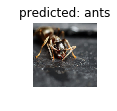

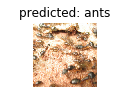

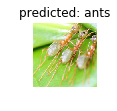

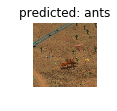

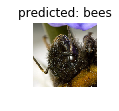

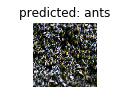

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

We first freeze all the layers by using `requires_grad = False`. We then replace the existing `fc` attribute with a new one, and this automatically sets `requires_grad=True`. We first visualize the structure of the ResNet18 model we will be using. The model is fairly big, with a large number of layers.

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
print(model_conv)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

We then redefine the fully connected layer. From the model, it seems not to be associated to a non-lilnearity, but it still maps the learned features to 1000 classes, where we need only two.

In [11]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1725 Acc: 0.6189
val Loss: 0.0712 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.0970 Acc: 0.8197
val Loss: 0.0529 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.1382 Acc: 0.7582
val Loss: 0.0684 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.0780 Acc: 0.8525
val Loss: 0.0859 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.1150 Acc: 0.8443
val Loss: 0.0475 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1206 Acc: 0.7664
val Loss: 0.0749 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.1577 Acc: 0.7623
val Loss: 0.0587 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0755 Acc: 0.8852
val Loss: 0.0700 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.1047 Acc: 0.8443
val Loss: 0.0485 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0847 Acc: 0.8484
val Loss: 0.0451 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0837 Acc: 0.8566
val Loss: 0.0547 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0851 Acc: 0.8607
val Loss: 0.0475 Acc: 0.9477

Ep

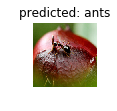

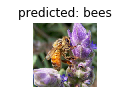

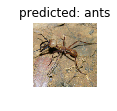

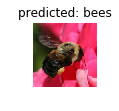

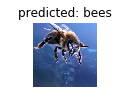

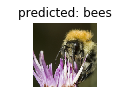

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()